In [ ]:
 
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *
from fastai.callbacks import OverSamplingCallback
os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"
 

In [2]:
path = Path("/media/subhaditya/DATA/COSMO/Datasets/100-bird-species/consolidated")
 

In [4]:
data = (ImageList.from_folder(path)
       .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(),size = 128)
       ).databunch(bs = 64).normalize(imagenet_stats)
 

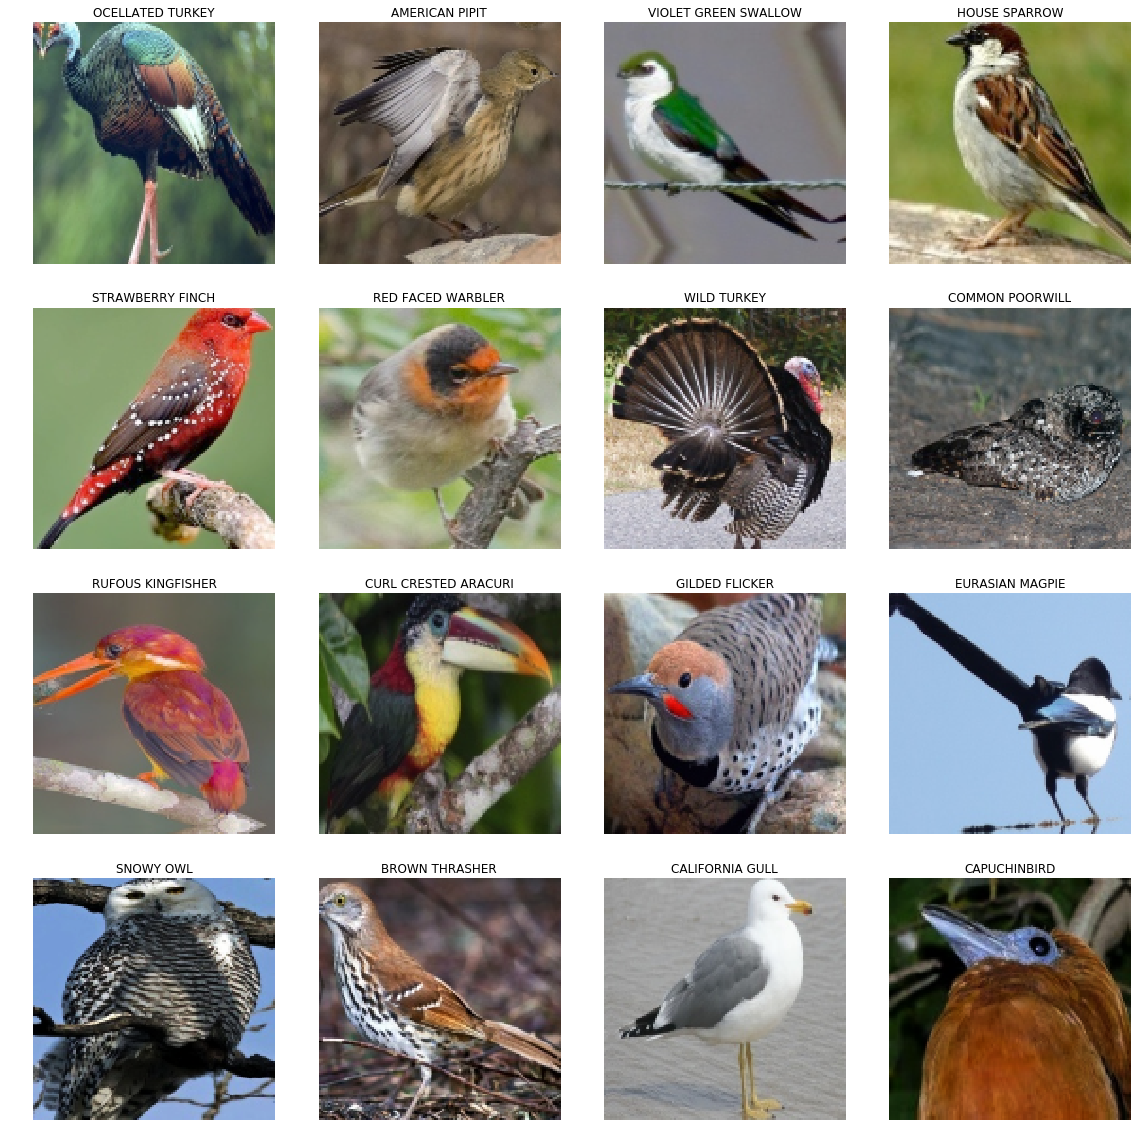

In [5]:
data.show_batch(4)

(array([2417., 2215., 2293., 2567., 2235., 2420., 2286., 2204., 2351., 2615.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2, 179.1, 199. ]),
 <a list of 10 Patch objects>)

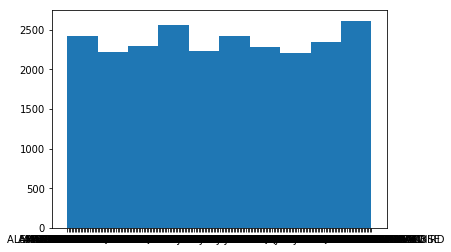

In [5]:
class_sam = [str(x) for x in data.train_ds.y]
plt.hist(class_sam)

In [6]:
data.c
 

200

In [15]:
learn = None
gc.collect()

8924

# Efficient net

In [14]:
from efficientnet_pytorch import EfficientNet

In [15]:
arch = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /media/subhaditya/DATA/COSMO/Datasets-Useful/checkpoints/adv-efficientnet-b0-b64d5a18.pth
100%|██████████| 20.4M/20.4M [00:14<00:00, 1.44MB/s]

Loaded pretrained weights for efficientnet-b0


In [17]:

arch._fc = nn.Linear(1280, data.c)

In [18]:
loss_func = LabelSmoothingCrossEntropy()

In [19]:
learn = Learner(data, arch, loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


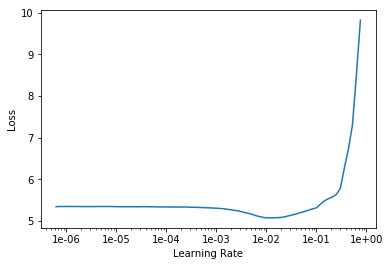

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.765308,1.709079,0.780000,00:51
1,1.327583,1.272815,0.911695,00:52
2,1.096295,1.133500,0.945763,00:50


In [22]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.338332,1.576220,0.815593,00:51
1,1.158228,1.206279,0.925593,00:50
2,1.012749,1.087170,0.950170,00:51


In [24]:
learn.validate()

[1.0871702, tensor(0.9502)]

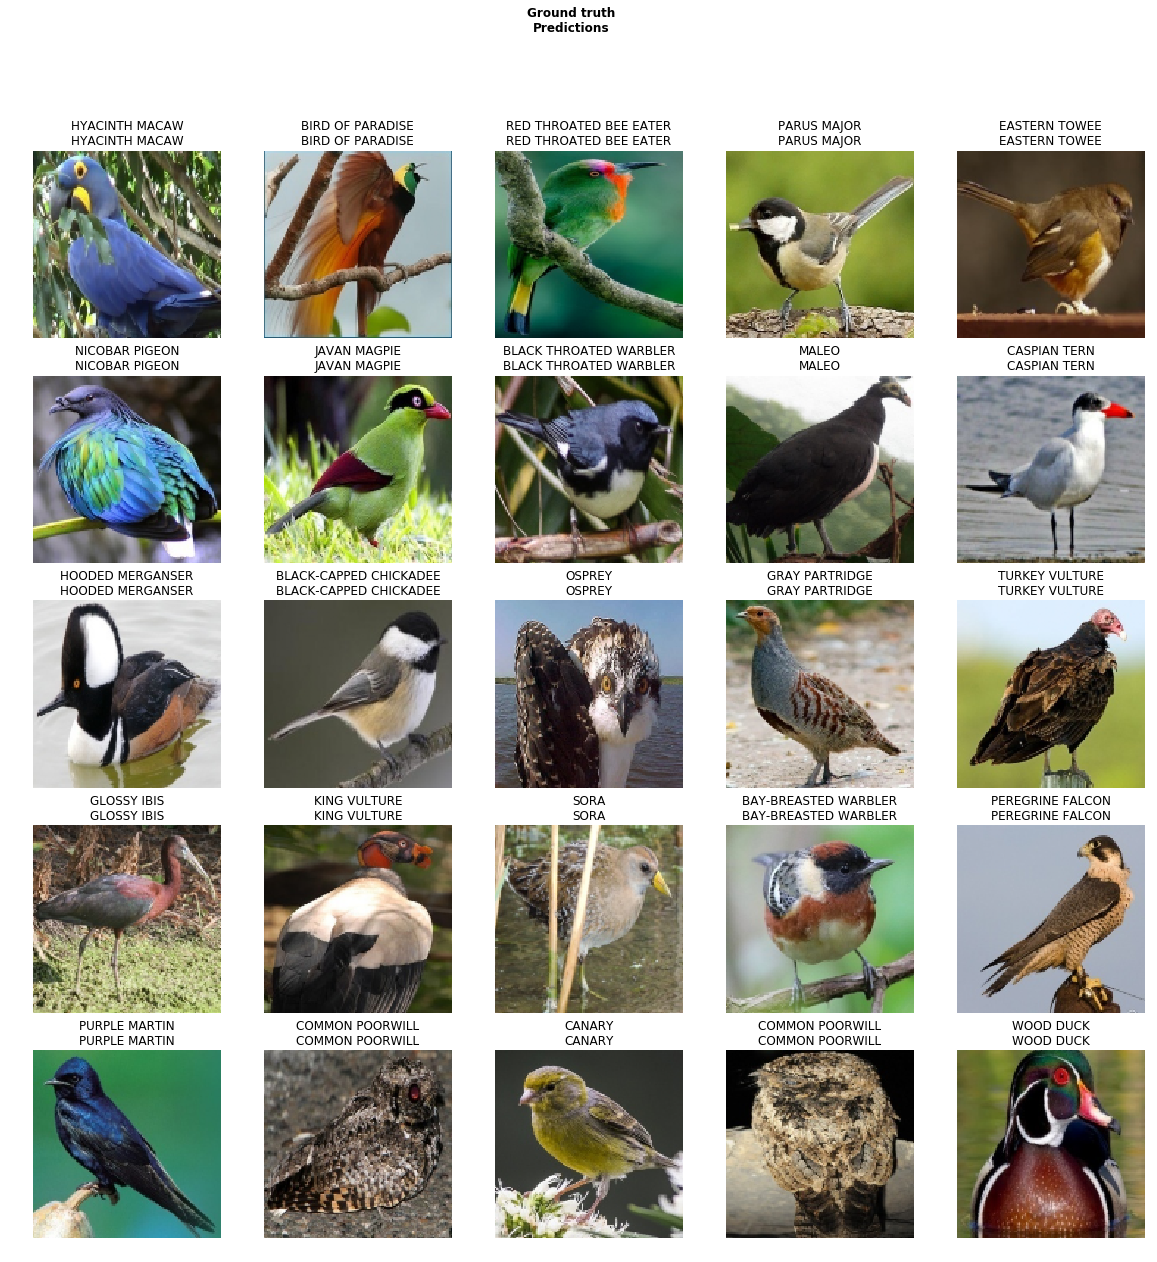

In [23]:
learn.show_results()

In [25]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

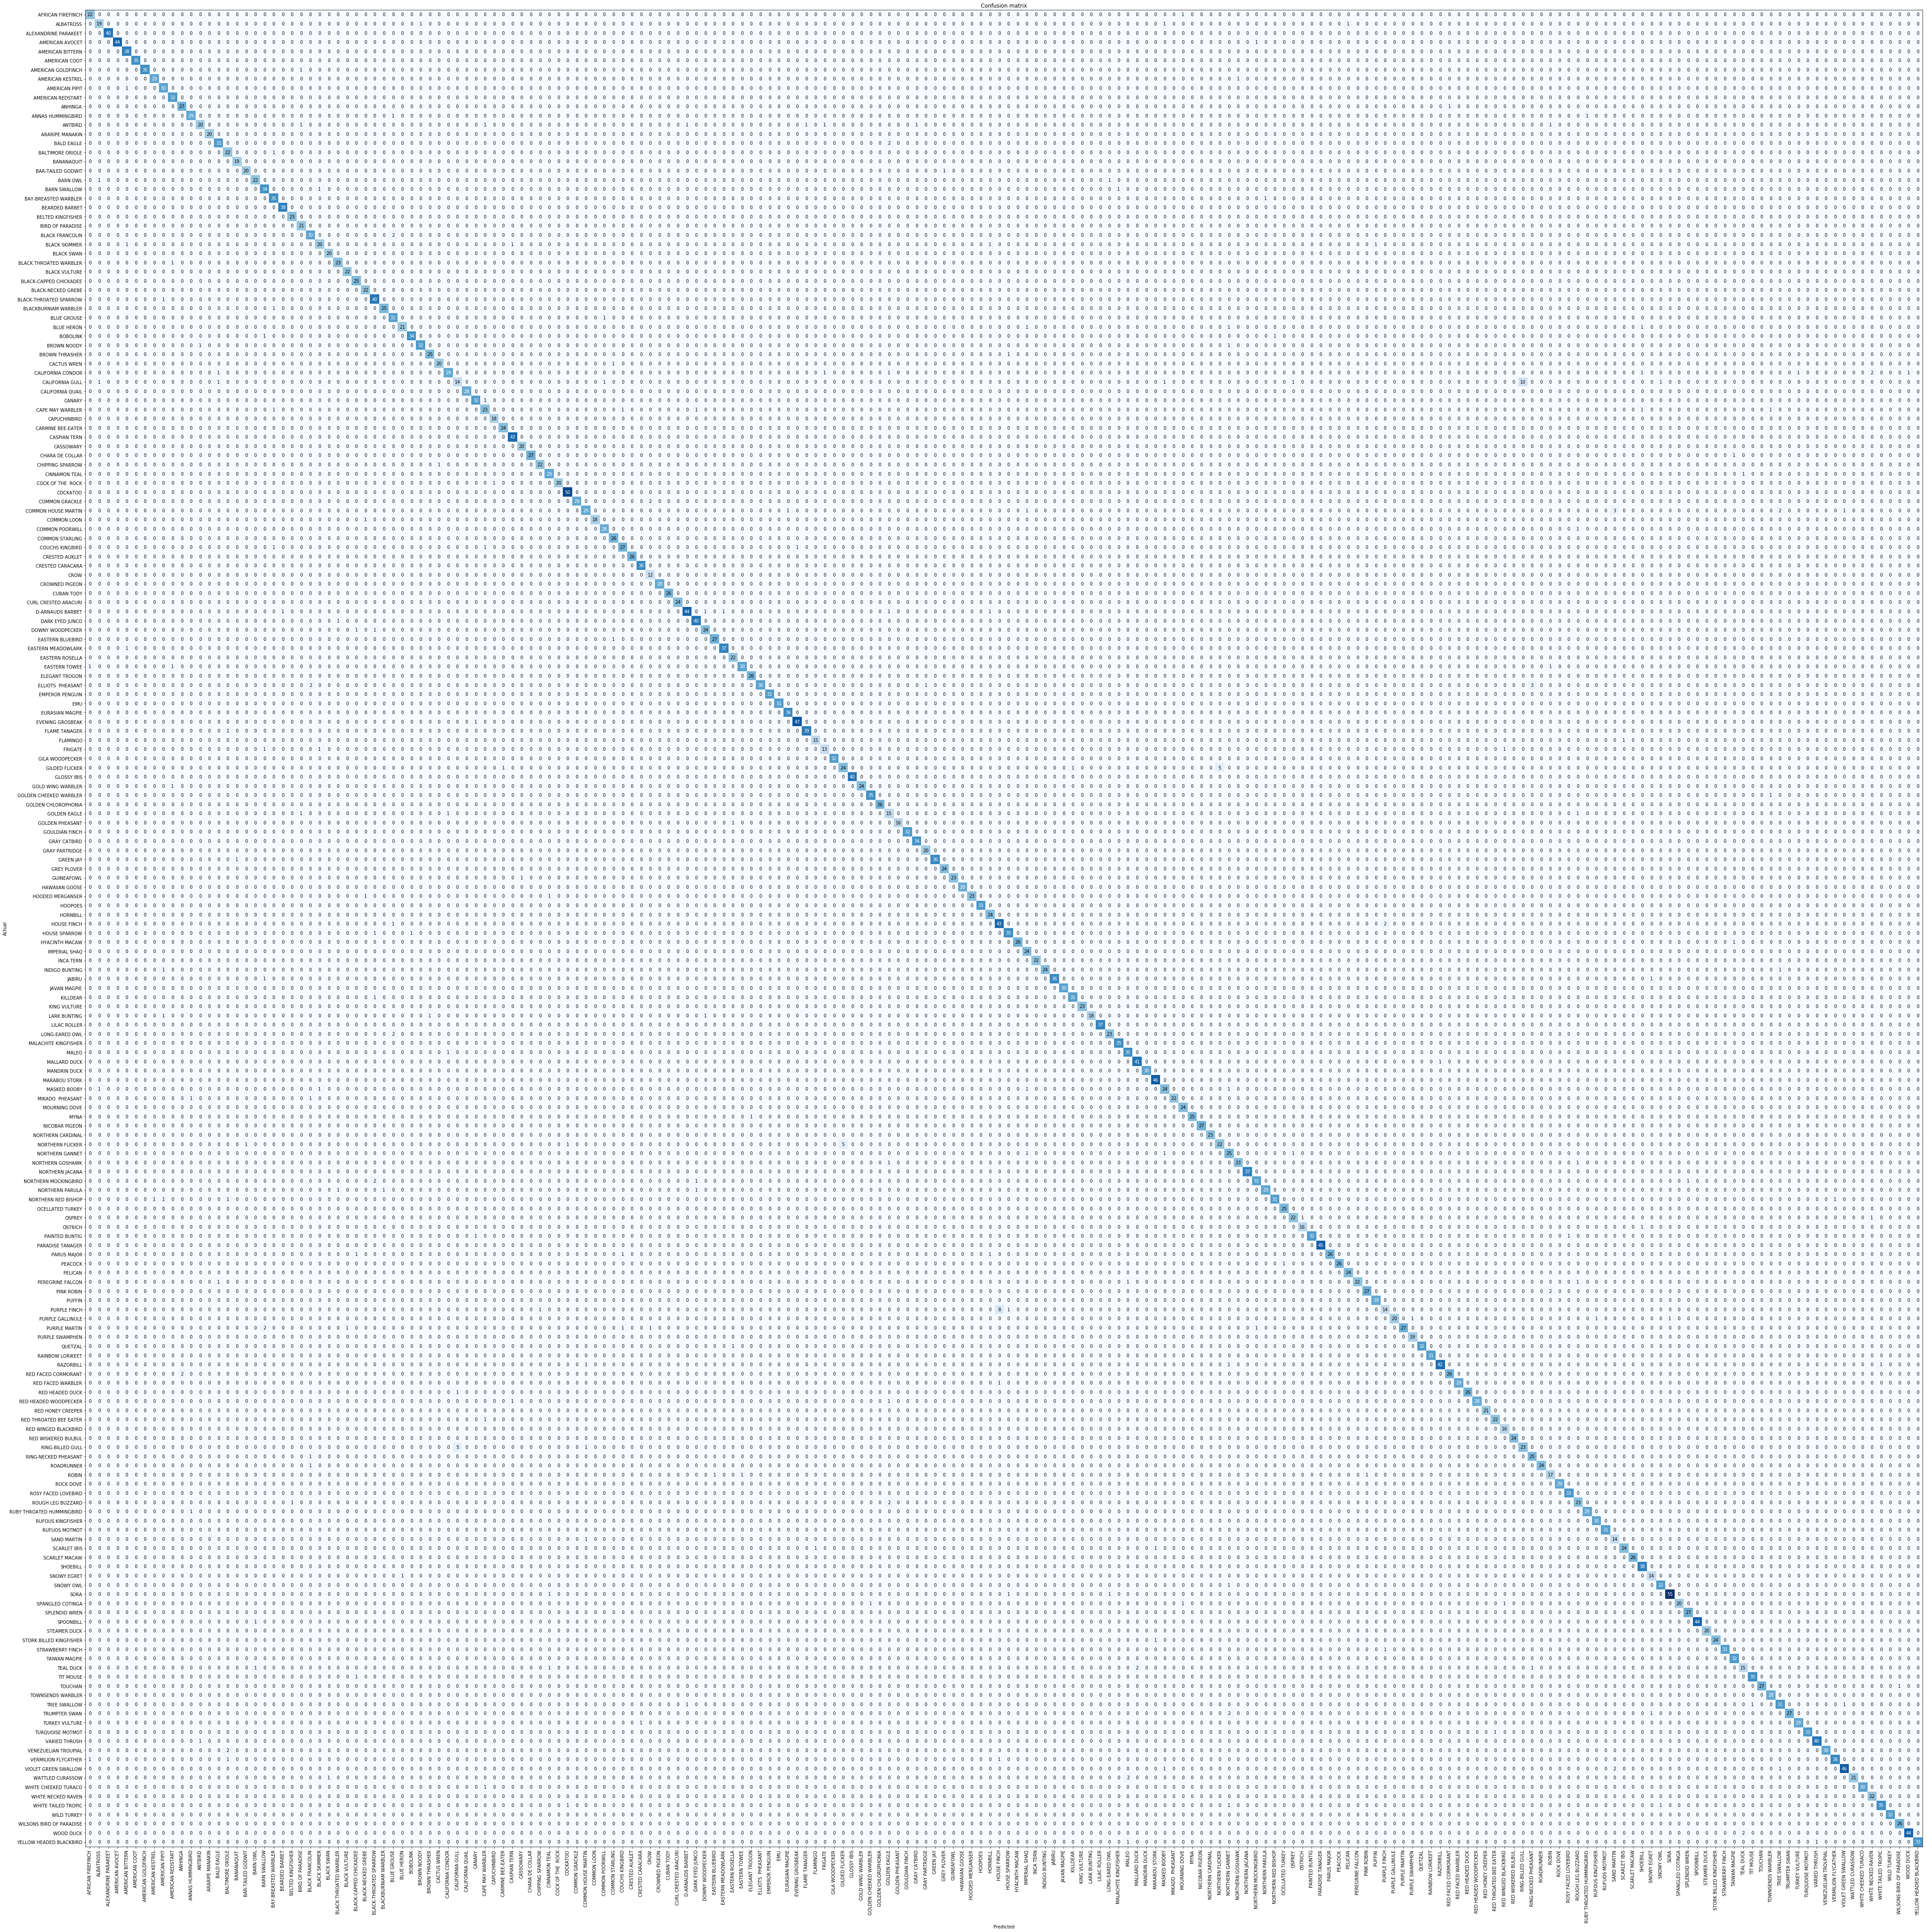

In [30]:
interp.plot_confusion_matrix(figsize=(60,60))

# Resnet18 no momentum

In [16]:
learn = cnn_learner(
    data, models.resnet18, metrics=[accuracy,error_rate], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


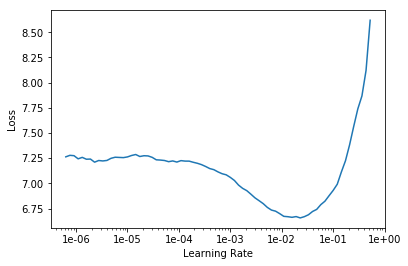

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.505069,0.890391,0.769661,0.230339,00:23
1,1.588820,1.724115,0.599153,0.400847,00:23
2,1.054232,1.019894,0.733729,0.266271,00:24
3,0.802268,0.948828,0.756441,0.243559,00:23
4,0.622911,0.621725,0.834746,0.165254,00:25
5,0.455490,0.515238,0.857966,0.142034,00:25
6,0.296208,0.411292,0.895424,0.104576,00:24
7,0.171332,0.341943,0.912712,0.087288,00:24
8,0.104492,0.306733,0.923898,0.076102,00:25
9,0.094130,0.302917,0.926102,0.073898,00:25


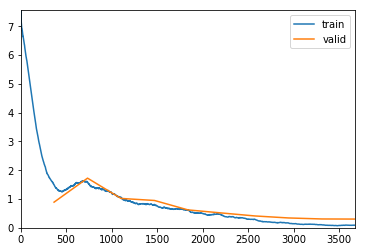

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-2), wd = 1e-3)
 

# Resnet18 momentum

In [6]:
learn = None
gc.collect()

31566

In [7]:
learn = cnn_learner(
    data, models.resnet18, metrics=[accuracy,error_rate], opt_func=AdamW, callback_fns=ShowGraph
)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


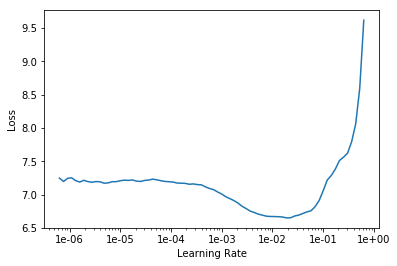

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.570867,7.992815,0.116102,0.883898,00:23
1,2.341571,2.794275,0.411186,0.588814,00:23
2,1.666070,1.662839,0.587797,0.412203,00:23
3,1.242339,1.407151,0.648136,0.351864,00:23
4,1.051653,0.990705,0.741356,0.258644,00:23
5,0.844301,0.799669,0.788305,0.211695,00:23
6,0.625836,0.603566,0.835254,0.164746,00:23
7,0.412645,0.427189,0.887119,0.112881,00:23
8,0.262886,0.353126,0.902373,0.097627,00:23
9,0.212635,0.342315,0.906271,0.093729,00:24


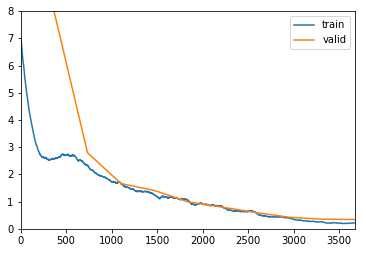

In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, wd = 1e-3,moms = (0.8,0.7))
 

# Resnet18 momentum

In [10]:
learn = None
gc.collect()

17046

In [11]:
learn = cnn_learner(
    data, models.resnet18, metrics=[accuracy,error_rate], opt_func=AdamW, callback_fns=ShowGraph
)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


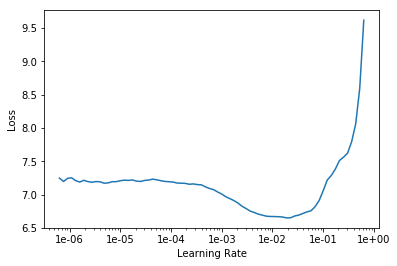

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.742177,2.950758,0.347627,0.652373,00:23
1,2.320305,2.234061,0.461525,0.538475,00:24
2,1.667970,1.637723,0.592712,0.407288,00:23
3,1.324087,1.304511,0.661695,0.338305,00:23
4,1.156816,1.038690,0.729831,0.270169,00:23
5,0.886908,0.831327,0.777966,0.222034,00:24
6,0.627914,0.603185,0.842373,0.157627,00:24
7,0.434048,0.472449,0.870170,0.129831,00:23
8,0.273203,0.381155,0.901695,0.098305,00:23
9,0.218119,0.366958,0.903051,0.096949,00:23


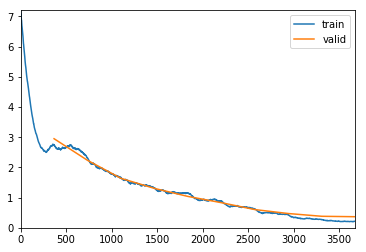

In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2,moms = (0.8,0.7))
 